<h1 align="center">Markov Chain Monte Carlo for fun and profit</h1>
<h1 align="center"> 🎲 ⛓️ 👉 🧪 </h1>

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

# This loads some custom styles for matplotlib
import json, matplotlib

with open("assets/matplotlibrc.json") as f:
    matplotlib.rcParams.update(json.load(f))

np.random.seed(
    42
)  # This makes our random numbers reproducable when the notebook is rerun in order


def show_state(state, ax=None):
    if ax is None:
        f, ax = plt.subplots()
    ax.matshow(state, cmap="Greys", vmin=-1, vmax=1)
    ax.set(xticks=[], yticks=[])

# Doing Monte Carlo!

Now that we can evaluate the energy of a state there isn't that much more work to do Markov Chain Monte Carlo on it. I won't go into the details of how MCMC works but put very simply:

We want to calculate thermal averages about a physical system. For example, is this bag of H20 molecules solid or liquid at T = -20C? Our Ising model is much simpler so the equivalent question would be what's the average color of this system at some T?

It turns out that this question is pretty hard to answer using maths, it can be done for the 2D Ising model but for anything more complicated it's pretty much impossible. This is where MCMC comes in. MCMC is a numerical method that gives us a rule to probalistically jump from one state of the system to another. 

If we perform many such jumps many times we get a (Markov) chain of states. The great thing about this chain is that if we average a measurement over it, such as looking at the average proportion of white pixels, the answer we get will be close to the real answer for this system and will converge closer and closer to the true answer as we extend the chain. 

I've written a very basic MCMC sampler for the 2D Ising model below. It needs:
- an initial start to start the chain
- to know how many steps to take
- the temperature we want to simulate at
- a way to measure the energy of a state, which we wrote in a previous chapter

It then loops over:
- modify the state a little, here we just flip one bond
- accepting $p = \exp(-\Delta_E / T)$ based on how the energy changed
- if we rejected, change the state back to how it was

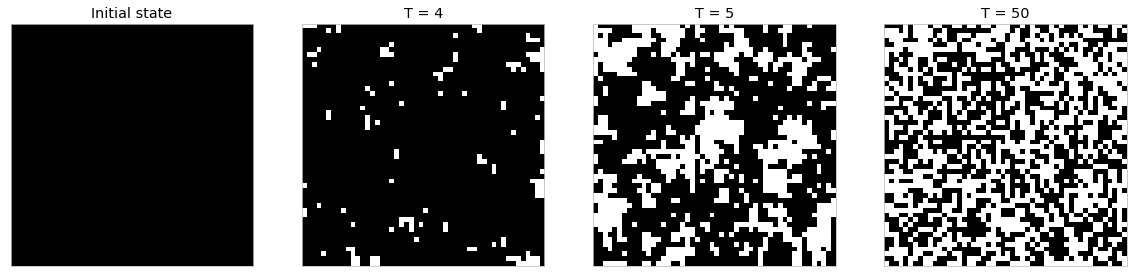

In [2]:
@jit(nopython=True, nogil=True)
def energy(state):
    E = 0
    N, M = state.shape
    for i in range(N):
        for j in range(M):
            # handle the north and south neighbours
            if 0 <= (i + 1) < N:
                E -= state[i, j] * state[i + 1, j]

            # handle the east and west neighbours
            if 0 <= (j + 1) < M:
                E -= state[i, j] * state[i, j + 1]

    return 2 * E / (N * M)


# While writing numba it's useful to keep the list of supported numpy functions open:
# https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html
@jit(nopython=True, nogil=True)
def mcmc(initial_state, steps, T, energy=energy):
    N, M = initial_state.shape
    assert N == M

    current_state = initial_state.copy()
    E = N**2 * energy(current_state)
    for i in range(steps):
        i, j = np.random.randint(N), np.random.randint(N)

        # modify the state a little, here we just flip a random pixel
        current_state[i, j] *= -1
        new_E = N**2 * energy(current_state)

        if (new_E < E) or np.exp(-(new_E - E) / T) > np.random.random():
            E = new_E
        else:
            current_state[i, j] *= -1  # reject the change we made

    return current_state


Ts = [4, 5, 50]

ncols = 1 + len(Ts)
f, axes = plt.subplots(ncols=ncols, figsize=(5 * ncols, 5))

initial_state = np.ones(shape=(50, 50))
axes[0].set(title="Initial state")
show_state(initial_state, ax=axes[0])

for T, ax in zip(Ts, axes[1:]):
    # initial_state = rng.choice([1,-1], size = (50,50))

    final_state = mcmc(initial_state, steps=100_000, T=T)
    show_state(final_state, ax=ax)
    ax.set(title=f"T = {T}")

These images give a flavour of why physicists find this model useful, it gives window into how thermal noise and spontaneous order interact. At low temperatures the energy cost of being different from your neighbours is the most important thing, while at high temperatures, it doesn't matter and you really just do your own thing.

There's a special point somewhere in the middle called the critical point $T_c$ where all sorts of cool things happen, but my favourite is that for large system sizes you get a kind of fractal behaviour which I will demonstrate more once we've sped this code up and can simulate larger systems in a reasonable time. You can kinda see it for 50x50 systesm at T = 5 but not really clearly.

The code we have so far is really just a sketch of a solution. So this is a good time to step back and think about what are aims are and how this software will fulfil them. I see three broad areas on which it needs improvement:

**Functionality**
Right now we can't really do much except print nice pictures of states, but (within the fiction of this project) we really want to be able to do science! So we need to think about what measurements and observations we might want to make and how that might affect the structure of our code.

**Testing**
I've already missed at least one devastating bug in this code, and there are almost certainly more! Before we start adding too much new code we should think about how to increase our confidence that the individual components are working correctly. It's very easy to build a huge project out of hundreds of functions, realise there's a bug and then struggle to find the source of that bug. If we test our components individually and thoroughly, we can avoid some of that pain.

**Performance**
Performance only matters in so far as it limits what we can do. And there is a real danger that trying to optimise for performance too early or in the wrong places will just lead to complexity that makes the code harder to read, harder to write and more likely to contain bugs. However I do want to show you the fractal states at the critical point, and I can't currently generate those images in a reasonable time, so some optimisation will happen!

## Functionality

The main thing we want to be able to do is to take measurements, the code as I have writting it doesn't really allow that because it only returns the final state in the chain. Let's say we have a measurement called `average_color(state)` that we want to average over the whole chain. We could just stick that inside our definition of `mcmc` but we know that we will likely make other measurements too and we don't want to keep writing new versions of our core functionality!

## Exercise 1
Have a think about how you would implement this and what options you have.

## Solution 1
So I chatted with my mentors on this project on how to best do this and we came up with a few ideas:

### Just save all the states and return them

The problem with this is the states are very big and we don't want to waste all that memory. For an NxN state that uses 8 bit integers (the smallest we can use in numpy) 1000 samples would already use 2.5Gb of memory! We will see later that we'd really like to be able to go a bit bigger than 50x50 and 1000 samples!

### Pass in a function to make measurements
```python

def mcmc(initial_state, steps, T, measurement, energy=energy):
    ...

    current_state = initial_state.copy()
    E = N**2 * energy(current_state)
    for i in range(steps):
        measurements[i] = measurement(state)
        ...

    return measurements
```

This could work but it limits how we can store measurements and what shape and type they can be. What if we want to store our measurements in a numpy array? Or what if your measurement itself is a vector or and object that can't easily be stored in a numpy array? We would have to think carefully about what functionality we want.

### Use Inheritance
```python
# This class would define the basic functionality of performing MCMC
class MCMCSampler(object):
    def run(self, initial_state, steps, T):
        ...
        for i in range(steps):
            self.measurement(state)

       
# This class would inherit from it and just implement the measurement
class AverageColorSampler(MCMCSampler):
    measurements = np.zeros(10)
    index = 0
    
    def measurement(self, state):
        self.measurements[self.index] = some_function(state)
        self.index += 1
        
color_sampler = AverageColorSampler(...)
measurements = color_sampler.run(...)
```

This would definitely work but I personally am not a huge fan of object oriented programming so I'm gonna skip this option!

## Use a generator
This is the approach I ended up settling on, we will use [python generator function](https://peps.python.org/pep-0255/). While you may not have come across generator functions before, you almost certainly will have come across generators, `range(n)` is a generator, `(i for i in [1,2,3])` is a generator. Generator functions are a way to build your own generators, by way of example here is range implemented as a generator function:

In [3]:
def my_range(n):
    "Behaves like the builtin range function of one argument"
    i = 0
    while i < n:
        yield i  # sends i out to whatever function called us
        i += 1
    return  # let's python know that we have nothing else to give


my_range(10), list(my_range(10))

(<generator object my_range at 0x7f86c6d87040>, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

This requires only a very small change to our mcmc function and suddenly we can do whatever we like with the states! While we're at it I'm going to add an aditional argument `stepsize` that allows us to only sample the state every `stepsize` MCMC steps. You'll see why we would want to set this to value greater than 1 in a moment.

In [4]:
@jit(nopython=True, nogil=True)
def mcmc_generator(initial_state, steps, T, stepsize=1000, energy=energy):
    N, M = initial_state.shape
    assert N == M

    current_state = initial_state.copy()
    E = N**2 * energy(current_state)
    for _ in range(steps):
        for _ in range(stepsize):
            i, j = np.random.randint(N), np.random.randint(N)

            # modify the state a little, here we just flip a random pixel
            current_state[i, j] *= -1
            new_E = N**2 * energy(current_state)

            if (new_E < E) or np.exp(-(new_E - E) / T) > np.random.random():
                E = new_E
            else:
                current_state[i, j] *= -1  # reject the change we made
        yield current_state.copy()
    return


N_steps = 1000
stepsize = 1
without_yield = %timeit -o mcmc(initial_state, steps = N_steps, T = 5)
with_yield = %timeit -o [np.mean(s) for s in mcmc_generator(initial_state, T = 5, steps = N_steps, stepsize = 1)]
print(f"{with_yield.best / without_yield.best:.0f}x slowdown!")

6.16 ms ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
15.3 ms ± 406 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
2x slowdown!


Fun fact: if you replace `yield current_state.copy()` with `yield current_state` your python kernel will crash when you run the code. I believe this is a bug in Numba that related to how pointers to numpy arrays work but let's not worry too much about it. 

We take a factor of two slowdown but that doesn't seem so much to pay for the fact we can now sample the state at every single step rather than just the last.

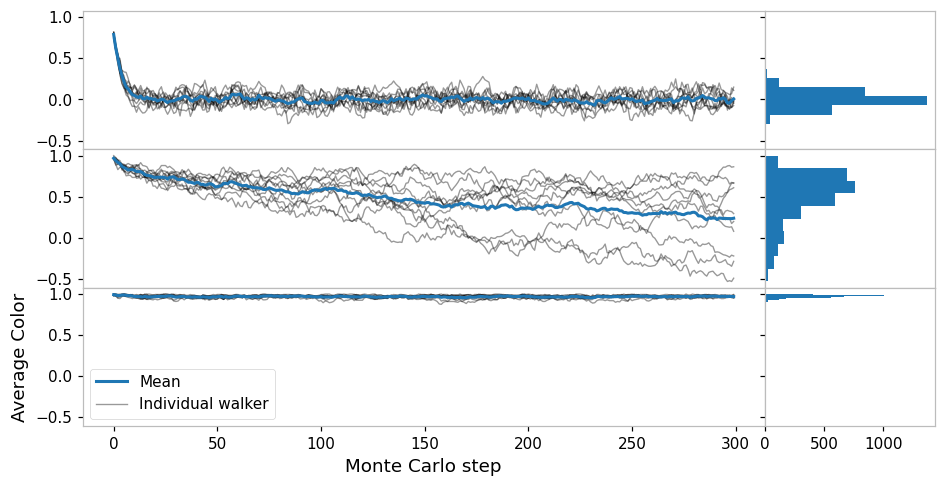

In [51]:
def average_color(state):
    return np.mean(state)


initial_state = np.ones(shape=(20, 20))

fig, axes = plt.subplots(
    figsize=(10, 5),
    nrows=3,
    ncols=2,
    sharey="all",
    sharex="col",
    gridspec_kw=dict(hspace=0, wspace=0, width_ratios=(4, 1)),
)

for T, ax, hist_ax in zip([10, 4.5, 3], axes[:, 0], axes[:, 1]):
    m = np.array(
        [
            [
                average_color(s)
                for s in mcmc_generator(initial_state, steps=300, stepsize=200, T=T)
            ]
            for _ in range(10)
        ]
    ).T
    indiv_line, *_ = ax.plot(m, alpha=0.4, color="k", linewidth=0.9)
    (mean_line,) = ax.plot(np.mean(m, axis=1))
    hist_ax.hist(m.flatten(), orientation="horizontal")


axes[-1, 0].set(xlabel="Monte Carlo step", ylabel="Average Color")
axes[-1, 0].legend([mean_line, indiv_line], ["Mean", "Individual walker"])